# Scoring Elaticsearch Results
### LMI Capstone Team
### Summer Chambers | Steve Morris | Kaleb Shikur

## Setup

In [1]:
import pandas as pd
import numpy as np
import json
import math
from statistics import mode
from sklearn.metrics import ndcg_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
metadata_url = "https://mikeanders.org/data/CMS/CMS-2018-0101-0001/CMS-1701-P%20Comment%20MetaData.csv"
data = pd.read_csv(metadata_url, usecols=range(0,36))[:468] #ignore last few columns and blank rows at end of csv 
data = data.rename(columns=lambda x: x.strip()) #strip whitespace from columns

In [3]:
data10 = data.fillna(0) #fill NaN with 0

section_cols = data10.columns[3:] 
data10[section_cols] = data10[section_cols].replace(["Y"], 1) #replace Y with 1 in approriate columns
data11 = data10.copy()
section_cols1  = data11.columns[3:] 
data11[section_cols1] = np.where((data11[section_cols1]  != 1), 0, data11[section_cols1])

# Combining columns for index matching: (A6b, A6b.1, = A6b),  (C3b, C3b.1'= C3b) ('A7', 'A7.1', 'A7.2', = A7b, a7c),  (F = F2, F3)

data11['A6b'] = (data11['A6b'] + data11['A6b.1'])
data11['A6b'] = data11['A6b'].replace(2,1)
data11['C3b'] = (data11['C3b'] + data11['C3b.1'])
data11['C3b'] = data11['C3b'].replace(2,1)
data11['A7'] = (data11['A7'] + data11['A7.1'] + data11['A7.2'])
data11['A7'] = data11['A7'].replace(2,1)
data11['A7'] = data11['A7'].replace(3,1)

data11 = data11.drop(['A6b.1', 'C3b.1', 'A7.1', 'A7.2'], axis=1)
data11.Name = [name.split('DRAFT-')[1].split('-')[0] for name in data11.Name]
data11 = data11.rename(columns=lambda x: x.lower())
section_cols1 = data11.columns[3:]

In [4]:
data11

name                 organization name / submitter name submitter state  \
0    0002                                      Erick Meleher              NC   
1    0003                                        Mayank Shah              IL   
2    0004                                        Mayank Shah              IL   
3    0005                                     Morey Menacker              NJ   
4    0006                                        Todd Rapoza              MA   
..    ...                                                ...             ...   
463  0465  Morehouse Choice Accountable Care Organization...              GA   
464  0466                                        Liberty ACO              TX   
465  0467              Washington State Hospital Association              WA   
466  0468                      Think Whole Person Healthcare              NE   
467  0469           Palm Beach Accountable Care Organization              FL   

     a2  a3  a4b  a4c  a5b  a5c  a5d  ...  d3c  d3d  d4  e2  e3  e4  e5  e6  \
0     0   0    0    0    0    0    0  ...    0    0   0   0   0   0   0   0   
1     0   0    0    0    0    0    0  ...    1    0   0   0   0   0   1   0   
2     0   0    0    0    0    0    0  ...    0    0   0   0   0   0   0   0   
3     0   0    0    0    1    0    0  ...    0    0   0   0   0   0   0   0   
4     0   0    0    0    0    0    0  ...    0    0   0   0   0   0   0   0   
..   ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..  ..  ..  ..  ..   
463   1   1    0    0    1    0    1  ...    1    0   0   0   0   0   0   1   
464   0   1    0    0    0    0    0  ...    0    0   0   0   0   0   0   0   
465   0   0    0    0    0    0    0  ...    0    0   0   0   0   0   0   0   
466   1   0    0    0    0    0    0  ...    0    0   0   0   0   0   0   0   
467   0   1    0    1    1    1    0  ...    1    0   0   0   1   1   0   1   

     e7  f  
0     0  0  
1     0  0  
2     0  0  
3     0  0  
4     0  1  
..   .. ..  
463   0  0  
464   0  0  
465   0  0  
466   0  0  
467   0  0  

[468 rows x 32 columns]

In [5]:
truth_dict = {} # initiate dict
for i, name in enumerate(data11.name): # iterate through Comment Names
    dict1 = {col:data11[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [6]:
with open("unique_comments2018.json") as f:
    unique_comments2018 = json.load(f)

In [7]:
unique_data = data11.loc[data11['name'].isin(unique_comments2018.keys())]

In [8]:
unique_truth_dict = {} # initiate dict
for i, name in enumerate(unique_data.name): # iterate through Comment Names
    dict1 = {col:unique_data[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    unique_truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [9]:
dump = json.dumps(unique_truth_dict)
f = open('unique_truth_dict.json','w')
f.write(dump)
f.close()

In [10]:
#define true rule section names
truth_keys = list(section_cols1)
truth_keys = [key1.lower() for key1 in truth_keys]

## Headers Standard Index Testing

In [11]:
with open('match_header_results.json') as f:
    unique_header_results = json.load(f)

In [12]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        unique_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [13]:
normalized_results = {}
for comment_idx, result in unique_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [14]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [15]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [16]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [17]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [18]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [19]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_header_results_all = unique_header_results.copy()
unique_binary_header_results_all = unique_header_results.copy()
for key, value in unique_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_header_results_all[key] = new_value_list_discounted
    unique_binary_header_results_all[key] = new_value_list_binary

In [20]:
unique_headers_ndcg = {}
unique_headers_ap = {}
unique_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_header_results_all.items()):
    unique_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_header_results_all.items()):
    unique_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [21]:
unique_headers_eval = pd.DataFrame(data=[unique_headers_ndcg, unique_headers_ap, unique_headers_f1]).T
unique_headers_eval = unique_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [22]:
unique_headers_eval.describe()

NDCG         AP         F1
count  94.000000  94.000000  94.000000
mean    0.497798   0.813862   0.739395
std     0.257016   0.203793   0.104969
min     0.000000   0.068966   0.190476
25%     0.321587   0.767370   0.731707
50%     0.502037   0.893465   0.765957
75%     0.679465   0.958766   0.791667
max     0.993542   1.000000   0.863636

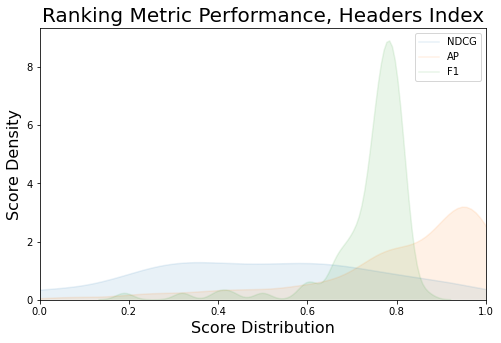

In [23]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [24]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [25]:
unique_headers_eval.query("NDCG == 0")

NDCG   AP        F1
0110   0.0  1.0  0.791667
0126   0.0  1.0  0.791667
0240   0.0  1.0  0.791667
0256   0.0  1.0  0.791667
0287   0.0  1.0  0.791667
0408   0.0  1.0  0.791667
0467   0.0  1.0  0.791667

In [26]:
poorf1 = unique_headers_eval.query("F1 < 0.5").F1
#poorf1

In [27]:
poorndcg = unique_headers_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
#poorndcg

In [28]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
#{key:len(comment) for key, comment in poorf1_comments.items()}

In [29]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
#poorf1_comments_truth

In [30]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
#{key:len(comment) for key, comment in poorndcg_comments.items()}

In [31]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
#poorndcg_comments_truth

## Headers Custom Index Testing

In [32]:
with open('match_header_custom_results.json') as f:
    custom_header_results = json.load(f)

In [33]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_header_results.items():
    value_list = []
    for val_idx, score in value.items():
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        custom_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     

### Normalize scores (divide by mean)

In [34]:
normalized_results = {}
for comment_idx, result in custom_header_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [35]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [36]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [37]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [38]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [39]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [40]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_header_results_all = custom_header_results.copy()
custom_binary_header_results_all = custom_header_results.copy()
for key, value in custom_header_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_header_results_all[key] = new_value_list_discounted
    custom_binary_header_results_all[key] = new_value_list_binary

In [41]:
custom_headers_ndcg = {}
custom_headers_ap = {}
custom_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_header_results_all.items()):
    custom_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_header_results_all.items()):
    custom_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [42]:
custom_headers_eval = pd.DataFrame(data=[custom_headers_ndcg, custom_headers_ap, custom_headers_f1]).T
custom_headers_eval = custom_headers_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [43]:
custom_headers_eval.describe()

NDCG         AP         F1
count  94.000000  94.000000  94.000000
mean    0.493490   0.817337   0.728662
std     0.249302   0.200828   0.112246
min     0.000000   0.068966   0.190476
25%     0.333333   0.770277   0.718641
50%     0.466673   0.900467   0.763931
75%     0.670601   0.958766   0.791667
max     1.000000   1.000000   0.863636

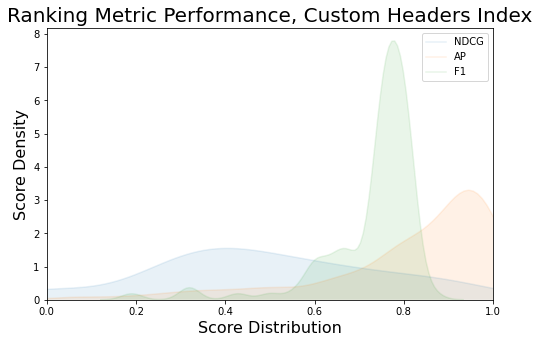

In [44]:
plt.figure(figsize = (8,5))
sns.kdeplot(custom_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(custom_headers_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(custom_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Custom Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Hybrid Standard Index Testing

In [45]:
with open('match_hybrid_results.json') as f1:
    unique_hybrid_results = json.load(f1)

In [46]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        unique_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [47]:
for comment_idx, tup_list in unique_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    unique_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [48]:
normalized_results = {}
for comment_idx, result in unique_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [49]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [50]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [51]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [52]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [53]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [54]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_hybrid_results_all = unique_hybrid_results.copy()
unique_binary_hybrid_results_all = unique_hybrid_results.copy()
for key, value in unique_hybrid_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    unique_hybrid_results_all[key] = new_value_list_discounted
    unique_binary_hybrid_results_all[key] = new_value_list_binary

In [55]:
unique_hybrid_ndcg = {}
unique_hybrid_ap = {}
unique_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_hybrid_results_all.items()):
    unique_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    unique_hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_hybrid_results_all.items()):
    unique_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [56]:
unique_hybrid_eval = pd.DataFrame(data=[unique_hybrid_ndcg, unique_hybrid_ap, unique_hybrid_f1]).T
unique_hybrid_eval = unique_hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [57]:
unique_hybrid_eval.describe()

NDCG         AP         F1
count  94.000000  94.000000  94.000000
mean    0.469845   0.822173   0.814973
std     0.251079   0.195252   0.141223
min     0.000000   0.068966   0.153846
25%     0.255925   0.759264   0.808511
50%     0.463493   0.918435   0.862745
75%     0.645953   0.970443   0.884615
max     0.989322   1.000000   0.943396

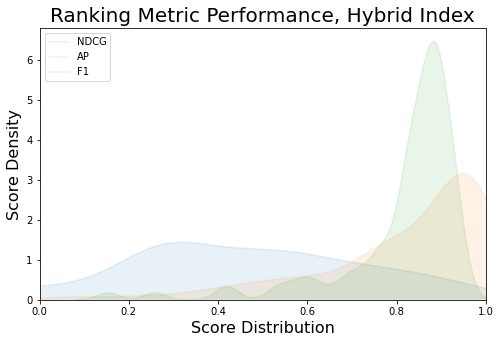

In [58]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(unique_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [59]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [60]:
unique_hybrid_eval.query("NDCG == 0")

NDCG   AP        F1
0110   0.0  1.0  0.905660
0126   0.0  1.0  0.925926
0240   0.0  1.0  0.925926
0256   0.0  1.0  0.925926
0287   0.0  1.0  0.925926
0408   0.0  1.0  0.905660
0467   0.0  1.0  0.925926

In [61]:
poorf1 = unique_hybrid_eval.query("F1 < 0.5").F1
#poorf1

In [62]:
poorndcg = unique_hybrid_eval.query("NDCG < 0.3 & NDCG > 0").NDCG
#poorndcg

In [63]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
#{key:len(comment) for key, comment in poorf1_comments.items()}

In [64]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
#poorf1_comments_truth

In [65]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
#{key:len(comment) for key, comment in poorndcg_comments.items()}

In [66]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
#poorndcg_comments_truth

## Hybrid Custom Index Testing

In [67]:
with open('match_hybrid_custom_results.json') as f1:
    custom_hybrid_results = json.load(f1)

In [68]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in custom_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        custom_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [69]:
for comment_idx, tup_list in custom_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    custom_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [70]:
normalized_results = {}
for comment_idx, result in custom_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [71]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [72]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [73]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [74]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [75]:
#create truth dict with values equal to sparse array length=29, binary
unique_truth_dict_all = unique_truth_dict.copy()
for key, value in unique_truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    unique_truth_dict_all[key] = new_value_list

In [76]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
custom_hybrid_results_all = custom_hybrid_results.copy()
custom_binary_hybrid_results_all = custom_hybrid_results.copy()
for key, value in custom_hybrid_results.items():
    new_value_list_discounted = np.zeros(len(truth_keys))
    new_value_list_binary = np.zeros(len(truth_keys))
    counter = 1
    for rule_section in value.keys():
        for i in range(len(truth_keys)):
            if rule_section == truth_keys[i]:
                counter += 1
                new_value_list_discounted[i] = 1/math.log(counter, 2)
                new_value_list_binary[i] = 1
    custom_hybrid_results_all[key] = new_value_list_discounted
    custom_binary_hybrid_results_all[key] = new_value_list_binary

In [77]:
custom_hybrid_ndcg = {}
custom_hybrid_ap = {}
custom_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_hybrid_results_all.items()):
    custom_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    custom_hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_hybrid_results_all.items()):
    custom_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [78]:
custom_hybrid_eval = pd.DataFrame(data=[custom_hybrid_ndcg, custom_hybrid_ap, custom_hybrid_f1]).T
custom_hybrid_eval = custom_hybrid_eval.rename({0:"NDCG", 1:"AP", 2:"F1"}, axis=1)

In [79]:
custom_hybrid_eval.describe()

NDCG         AP         F1
count  94.000000  94.000000  94.000000
mean    0.486038   0.823075   0.802251
std     0.252497   0.189674   0.148126
min     0.000000   0.068966   0.148148
25%     0.267322   0.750377   0.775198
50%     0.471043   0.908507   0.859944
75%     0.683715   0.970135   0.884615
max     1.000000   1.000000   0.943396

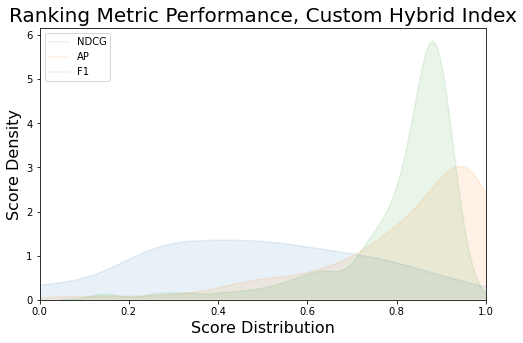

In [80]:
plt.figure(figsize = (8,5))
sns.kdeplot(custom_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(custom_hybrid_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(custom_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Custom Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Compare different indices

In [81]:
df_list = [unique_headers_eval, custom_headers_eval, unique_hybrid_eval, custom_hybrid_eval]
mean_df_list = [df.mean() for df in df_list]

In [82]:
comparison = pd.DataFrame(mean_df_list).T.rename({i:df for i, df in enumerate(["Std Hdr", "Cst Hdr", "Std Hyb", "Cst Hyb"])},\
                                                 axis=1).rename({"AP":"MAP"})
comparison

Std Hdr   Cst Hdr   Std Hyb   Cst Hyb
NDCG  0.497798  0.493490  0.469845  0.486038
MAP   0.813862  0.817337  0.822173  0.823075
F1    0.739395  0.728662  0.814973  0.802251